In [56]:
import numpy as np
import scipy as sp
from numpy import linalg as la
import matplotlib.pyplot as plt
from numpy import linalg as LA;
from scipy import linalg as LA2;
from numpy import random as rand
from scipy.sparse import diags
from scipy.sparse import csr_matrix

seed = 0

In [57]:
def tensorvect(a,b):
    return(np.tensordot(a,b,axes=0).flatten())

def tensorvectop(a,b):
    return np.kron(a,b)

def opchain(a,i,nspin):
    if i==1:
        return np.kron(a,np.identity(2**(nspin-1)))
    else:
        if i==nspin:
            return np.kron(np.identity(2**(nspin-1)),a)
        else:
            return np.kron(np.kron(np.identity(2**(i-1)),a),np.identity(2**(nspin-i)))
        
def opchain2(a,i,b,j,nspin):
    if i==1:
        if j==nspin:
            return np.kron(np.kron(a,np.identity(2**(nspin-2))),b)
        else:
            return np.kron(np.kron(a,np.identity(2**(j-2))),np.kron(b,np.identity(2**(nspin-j))))      
    else:
        if j==nspin:
            return np.kron(np.kron(np.identity(2**(i-1)),a),np.kron(np.identity(2**(nspin-(i+1))),b))
        else:
            return np.kron(np.kron(np.kron(np.identity(2**(i-1)),a),np.kron(np.identity(2**(j-(i+1))),b)),np.identity(2**(nspin-j)))
            
def buildstate(bin):
    v=[0. for i in range(2**len(bin))];
    v[int(bin,2)]=1.
    return np.array(v)


def diracrep(psi,nspin):
    state='';
    for i in range(2**nspin):
        if abs(psi[i])>10**(-6):
            state=state+'+'+str(psi[i])+'|'+format(i,'0'+str(nspin)+'b')+'>'
    return state

def binnum(n):
    l=['0','1'];
    if n==1:
        return l
    else:
        return ['0'+i for i in binnum(n-1)]+['1'+i for i in binnum(n-1)]
    
def densmat(psi,i,nspin):
    if i>1:
        listindex0=binnum(i-1)
        listindex0=[j+'0' for j in listindex0]
    else:
        listindex0=['0']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex0=list(np.array([[j+k for k in listcomp] for j in listindex0]).flatten())
    if i>1:
        listindex1=binnum(i-1)
        listindex1=[j+'1' for j in listindex1]
    else:
        listindex1=['1']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex1=list(np.array([[j+k for k in listcomp] for j in listindex1]).flatten())
    rho00=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex0)
    rho11=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex1)
    rho01=sum(psi[int(j,2)]*np.conjugate(psi[int(listindex1[listindex0.index(j)],2)]) for j in listindex0)
    return np.array([[rho00,rho01],[np.conjugate(rho01),rho11]])

def avdensmat(psi,nspin):
    rho=densmat(psi,1,nspin);
    if nspin>1:
        for i in range(2,nspin+1):
            rho=rho+densmat(psi,i,nspin)
    rho=rho/nspin;
    return rho

def purity(rho):
    rho2 = np.dot(rho,rho)
    tr = np.trace(rho2)
    return(tr)

def SvN(rho):
    vp=np.real(LA.eigvals(rho));
    S=0.;
    for i in range(len(vp)):
        if vp[i]>0.:
            S=S+vp[i]*np.log(vp[i])
    return -S

def entangl(psi,nspin):
    S=SvN(densmat(psi,1,nspin));
    if nspin>1:
        for i in range(2,nspin+1):
            S=S+SvN(densmat(psi,i,nspin))
    return S/nspin

def Disorder(psi,nspin):
    return SvN(avdensmat(psi,nspin))-entangl(psi,nspin)

In [58]:
sigX=np.array([[0.,1.],[1.,0.]]);
sigY=np.array([[0.,-1j],[1j,0.]]);
sigZ=np.array([[1.,0.],[0.,-1.]]);
sig1=np.array([[1.,0.],[0.,0.]]);
id2 =np.array([[1.,0.],[0.,1.]]);

NOT=sigX;
HAD1=np.array([[1./np.sqrt(2.),1./np.sqrt(2.)],[1./np.sqrt(2.),-1./np.sqrt(2.)]]);
CNOT=np.array([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,0.,1.],[0.,0.,1.,0.]]);
HAD2=np.array([[0.5,0.5,0.5,0.5],[0.5,-0.5,0.5,-0.5],[0.5,0.5,-0.5,-0.5],[0.5,-0.5,-0.5,0.5]]);
SWAP=np.array([[1.,0.,0.,0.],[0.,0.,1.,0.],[0.,1.,0.,0.],[0.,0.,0.,1.]]);

# Student code starts here:

In [59]:
def QuantumHamiltonian_chain(Jxyz, w, N, flag, force_real):
    h0 = np.array([[-w,0],[0,0]])
    H0 = np.zeros(shape=(2**N,2**N), dtype=np.complex128)
    Hint = np.copy(H0)
    for i in range(1,N+1):
        H0 += opchain(h0,i,N)
        
    for i in range(1,N):
        j = i+1

        Hint -= (Jxyz[0]*opchain2(0.5*sigX,i,0.5*sigX,j,N)+Jxyz[1]*opchain2(0.5*sigY,i,0.5*sigY,j,N)+Jxyz[2]*opchain2(0.5*sigZ,i,0.5*sigZ,j,N))
    if (flag=="close" and N>2):
        Hint -= (Jxyz[0]*opchain2(0.5*sigX,1,0.5*sigX,N,N)+Jxyz[1]*opchain2(0.5*sigY,1,0.5*sigY,N,N)+Jxyz[2]*opchain2(0.5*sigZ,1,0.5*sigZ,N,N))
    H = H0+Hint

    if force_real == True:
        H = H.real

    return H

def QuantumHamiltonian_general(J, w, N, flag, force_real):
    if type(w)==float:
        h0 = np.array([[-w,0],[0,0]])
    H0 = np.zeros(shape=(2**N,2**N), dtype=np.complex128)
    Hint = np.copy(H0)
    for i in range(1,N+1):
        if type(w)!=float:
            h0 = np.array([[-w[i-1],0],[0,0]])
        H0 += opchain(h0,i,N)
        
    for i in range(1,N+1):
        for j in range(1,N+1):
            if j>i:
                Hint -= (J[i-1,j-1,0]*opchain2(0.5*sigX,i,0.5*sigX,j,N)+J[i-1,j-1,1]*opchain2(0.5*sigY,i,0.5*sigY,j,N)+J[i-1,j-1,2]*opchain2(0.5*sigZ,i,0.5*sigZ,j,N))
    if (flag=="close" and N>2):
        Hint -= (J[0,N-1,0]*opchain2(0.5*sigX,1,0.5*sigX,N,N)+J[0,N-1,1]*opchain2(0.5*sigY,1,0.5*sigY,N,N)+J[0,N-1,2]*opchain2(0.5*sigZ,1,0.5*sigZ,N,N))
    H = H0+Hint

    if force_real == True:
        H = H.real

    return H

### 2.1 Studied models: Hamiltonian tests for different lattices and different sizes (N=2,3,8):

In [60]:
# (1) open Ising-Z spin chain

H_oIZ_2 = QuantumHamiltonian_chain(Jxyz=[0,0,1], w=0.5, N=2, flag="open", force_real=True)
H_oIZ_3 = QuantumHamiltonian_chain(Jxyz=[0,0,1], w=0.5, N=3, flag="open", force_real=True)
H_oIZ_8 = QuantumHamiltonian_chain(Jxyz=[0,0,1], w=0.5, N=8, flag="open", force_real=True)

print(f"N=2 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_oIZ_2,3)}\n\n")
print(f"N=3 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_oIZ_3,3)}\n\n")
print(f"N=8:\n{csr_matrix(H_oIZ_8)}")

N=2 (we rounded random outputs to see a proper matrix on screen):
[[-1.25  0.    0.    0.  ]
 [ 0.   -0.25  0.    0.  ]
 [ 0.    0.   -0.25  0.  ]
 [ 0.    0.    0.   -0.25]]


N=3 (we rounded random outputs to see a proper matrix on screen):
[[-2.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5]]


N=8:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 256 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-5.75
  (1, 1)	-4.75
  (2, 2)	-4.25
  (3, 3)	-4.25
  (4, 4)	-4.25
  (5, 5)	-3.25
  (6, 6)	-3.75
  (7, 7)	-3.75
  (8, 8)	-4.25
  (9, 9)	-3.25
  (10, 10)	-2.75
  (11, 11)	-2.75
  (12, 12)	-3.75
  (13, 13)	-2.75
  (14, 14)	-3.25
  (15, 15)	-3.25
  (16, 16)	-4.25
  (17, 17)	-3.25

In [61]:
# (2) closed Ising-Z spin chain

H_cIZ_2 = QuantumHamiltonian_chain(Jxyz=[0,0,1], w=0.5, N=2, flag="close", force_real=True)
H_cIZ_3 = QuantumHamiltonian_chain(Jxyz=[0,0,1], w=0.5, N=3, flag="close", force_real=True)
H_cIZ_8 = QuantumHamiltonian_chain(Jxyz=[0,0,1], w=0.5, N=8, flag="close", force_real=True)

print(f"N=2 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_cIZ_2,3)}\n\n")
print(f"N=3 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_cIZ_3,3)}\n\n")
print(f"N=8:\n{csr_matrix(H_cIZ_8)}")

N=2 (we rounded random outputs to see a proper matrix on screen):
[[-1.25  0.    0.    0.  ]
 [ 0.   -0.25  0.    0.  ]
 [ 0.    0.   -0.25  0.  ]
 [ 0.    0.    0.   -0.25]]


N=3 (we rounded random outputs to see a proper matrix on screen):
[[-2.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.75  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.75  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.25  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.75  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.25  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.25  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.75]]


N=8:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 254 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-6.0
  (1, 1)	-4.5
  (2, 2)	-4.5
  (3, 3)	-4.0
  (4, 4)	-4.5
  (5, 5)	-3.0
  (6, 6)	-4.0
  (7, 7)	-3.5
  (8, 8)	-4.5
  (9, 9)	-3.0
  (10, 10)	-3.0
  (11, 11)	-2.5
  (12, 12)	-4.0
  (13, 13)	-2.5
  (14, 14)	-3.5
 

In [62]:
# (3) open Ising-X spin chain

H_oIX_2 = QuantumHamiltonian_chain(Jxyz=[1,0,0], w=0.5, N=2, flag="open", force_real=True)
H_oIX_3 = QuantumHamiltonian_chain(Jxyz=[1,0,0], w=0.5, N=3, flag="open", force_real=True)
H_oIX_8 = QuantumHamiltonian_chain(Jxyz=[1,0,0], w=0.5, N=8, flag="open", force_real=True)

print(f"N=2 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_oIX_2,3)}\n\n")
print(f"N=3 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_oIX_3,3)}\n\n")
print(f"N=8:\n{csr_matrix(H_oIX_8)}")

N=2 (we rounded random outputs to see a proper matrix on screen):
[[-1.    0.    0.   -0.25]
 [ 0.   -0.5  -0.25  0.  ]
 [ 0.   -0.25 -0.5   0.  ]
 [-0.25  0.    0.    0.  ]]


N=3 (we rounded random outputs to see a proper matrix on screen):
[[-1.5   0.    0.   -0.25  0.    0.   -0.25  0.  ]
 [ 0.   -1.   -0.25  0.    0.    0.    0.   -0.25]
 [ 0.   -0.25 -1.    0.   -0.25  0.    0.    0.  ]
 [-0.25  0.    0.   -0.5   0.   -0.25  0.    0.  ]
 [ 0.    0.   -0.25  0.   -1.    0.    0.   -0.25]
 [ 0.    0.    0.   -0.25  0.   -0.5  -0.25  0.  ]
 [-0.25  0.    0.    0.    0.   -0.25 -0.5   0.  ]
 [ 0.   -0.25  0.    0.   -0.25  0.    0.    0.  ]]


N=8:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2047 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-4.0
  (0, 3)	-0.25
  (0, 6)	-0.25
  (0, 12)	-0.25
  (0, 24)	-0.25
  (0, 48)	-0.25
  (0, 96)	-0.25
  (0, 192)	-0.25
  (1, 1)	-3.5
  (1, 2)	-0.25
  (1, 7)	-0.25
  (1, 13)	-0.25
  (1, 25)	-0.25
  (1, 49)	-0.25
  (

In [63]:
# (4) open Heisenberg-XXX spin chain

H_oHXXX_2 = QuantumHamiltonian_chain(Jxyz=[1,1,1], w=0.5, N=2, flag="open", force_real=True)
H_oHXXX_3 = QuantumHamiltonian_chain(Jxyz=[1,1,1], w=0.5, N=3, flag="open", force_real=True)
H_oHXXX_8 = QuantumHamiltonian_chain(Jxyz=[1,1,1], w=0.5, N=8, flag="open", force_real=True)

print(f"N=2 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_oHXXX_2,3)}\n\n")
print(f"N=3 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_oHXXX_3,3)}\n\n")
print(f"N=8:\n{csr_matrix(H_oHXXX_8)}")

N=2 (we rounded random outputs to see a proper matrix on screen):
[[-1.25  0.    0.    0.  ]
 [ 0.   -0.25 -0.5   0.  ]
 [ 0.   -0.5  -0.25  0.  ]
 [ 0.    0.    0.   -0.25]]


N=3 (we rounded random outputs to see a proper matrix on screen):
[[-2.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.  -0.5  0.   0.   0.   0.   0. ]
 [ 0.  -0.5 -0.5  0.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.  -0.5  0.   0. ]
 [ 0.   0.  -0.5  0.  -1.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.  -0.5  0. ]
 [ 0.   0.   0.   0.   0.  -0.5 -0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5]]


N=8:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1152 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-5.75
  (1, 1)	-4.75
  (1, 2)	-0.5
  (2, 1)	-0.5
  (2, 2)	-4.25
  (2, 4)	-0.5
  (3, 3)	-4.25
  (3, 5)	-0.5
  (4, 2)	-0.5
  (4, 4)	-4.25
  (4, 8)	-0.5
  (5, 3)	-0.5
  (5, 5)	-3.25
  (5, 6)	-0.5
  (5, 9)	-0.5
  (6, 5)	-0.5
  (6, 6)	-3.75
  (6, 10)	-0.5
  (7, 7)	-3.75
  (7, 11)

In [64]:
# (5) open Heisenberg-XYZ spin chain

H_oHXXX_2 = QuantumHamiltonian_chain(Jxyz=[0.5,1,1.5], w=0.5, N=2, flag="open", force_real=True)
H_oHXXX_3 = QuantumHamiltonian_chain(Jxyz=[0.5,1,1.5], w=0.5, N=3, flag="open", force_real=True)
H_oHXXX_8 = QuantumHamiltonian_chain(Jxyz=[0.5,1,1.5], w=0.5, N=8, flag="open", force_real=True)

print(f"N=2 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_oHXXX_2,3)}\n\n")
print(f"N=3 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_oHXXX_3,3)}\n\n")
print(f"N=8:\n{csr_matrix(H_oHXXX_8)}")

N=2 (we rounded random outputs to see a proper matrix on screen):
[[-1.375  0.     0.     0.125]
 [ 0.    -0.125 -0.375  0.   ]
 [ 0.    -0.375 -0.125  0.   ]
 [ 0.125  0.     0.    -0.375]]


N=3 (we rounded random outputs to see a proper matrix on screen):
[[-2.25   0.     0.     0.125  0.     0.     0.125  0.   ]
 [ 0.    -1.    -0.375  0.     0.     0.     0.     0.125]
 [ 0.    -0.375 -0.25   0.    -0.375  0.     0.     0.   ]
 [ 0.125  0.     0.    -0.5    0.    -0.375  0.     0.   ]
 [ 0.     0.    -0.375  0.    -1.     0.     0.     0.125]
 [ 0.     0.     0.    -0.375  0.     0.25  -0.375  0.   ]
 [ 0.125  0.     0.     0.     0.    -0.375 -0.5    0.   ]
 [ 0.     0.125  0.     0.     0.125  0.     0.    -0.75 ]]


N=8:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2048 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-6.625
  (0, 3)	0.125
  (0, 6)	0.125
  (0, 12)	0.125
  (0, 24)	0.125
  (0, 48)	0.125
  (0, 96)	0.125
  (0, 192)	0.125
  (1, 1)	-5.3

In [65]:
# (6) open random Ising-X spin chain with random Larmor frequencies

np.random.seed(seed) #uncomment if you want always the same results

w_rand = lambda N: np.random.uniform(0,0.5,N)
def build_J_X(N):
    J = np.zeros(shape=(N,N,3))
    for i in range(N-1):
            J[i,i+1,0] = np.random.uniform(-1,1)
    return J

H_orIX_2 = QuantumHamiltonian_general(build_J_X(2), w_rand(2), N=2, flag="open", force_real=True)
H_orIX_3 = QuantumHamiltonian_general(build_J_X(3), w_rand(3), N=3, flag="open", force_real=True)
H_orIX_8 = QuantumHamiltonian_general(build_J_X(8), w_rand(8), N=8, flag="open", force_real=True)

print(f"N=2 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_orIX_2,3)}\n\n")
print(f"N=3 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_orIX_3,3)}\n\n")
print(f"N=8:\n{csr_matrix(H_orIX_8)}")

N=2 (we rounded random outputs to see a proper matrix on screen):
[[-0.659  0.     0.    -0.024]
 [ 0.    -0.358 -0.024  0.   ]
 [ 0.    -0.024 -0.301  0.   ]
 [-0.024  0.     0.     0.   ]]


N=3 (we rounded random outputs to see a proper matrix on screen):
[[-0.988  0.     0.     0.038  0.     0.    -0.022  0.   ]
 [ 0.    -0.542  0.038  0.     0.     0.     0.    -0.022]
 [ 0.     0.038 -0.769  0.    -0.022  0.     0.     0.   ]
 [ 0.038  0.     0.    -0.323  0.    -0.022  0.     0.   ]
 [ 0.     0.    -0.022  0.    -0.665  0.     0.     0.038]
 [ 0.     0.     0.    -0.022  0.    -0.219  0.038  0.   ]
 [-0.022  0.     0.     0.     0.     0.038 -0.446  0.   ]
 [ 0.    -0.022  0.     0.     0.038  0.     0.     0.   ]]


N=8:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2047 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-2.413696355294447
  (0, 3)	0.21448197090105653
  (0, 6)	-0.21279831914633052
  (0, 12)	-0.034022280546966155
  (0, 24)	-0.01444745

In [66]:
# (7) open random Spin Glass with random Larmor frequencies

np.random.seed(seed)

w_rand = lambda N: np.random.uniform(0,0.5,N)
def build_JXYZ(N):
    J = np.zeros(shape=(N,N,3))
    for i in range(N):
        for j in range(N):
            if j>i:
                J[i,j] = np.random.uniform(-1,1,3)
    return J

H_SP_2 = QuantumHamiltonian_general(build_JXYZ(2), w_rand(2), N=2, flag="close", force_real=True)
H_SP_3 = QuantumHamiltonian_general(build_JXYZ(3), w_rand(3), N=3, flag="close", force_real=True)
H_SP_8 = QuantumHamiltonian_general(build_JXYZ(8), w_rand(8), N=8, flag="close", force_real=True)

print(f"N=2 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_SP_2,3)}\n\n")
print(f"N=3 (we rounded random outputs to see a proper matrix on screen):\n{np.around(H_SP_3,3)}\n\n")
print(f"N=8:\n{csr_matrix(H_SP_8)}")

N=2 (we rounded random outputs to see a proper matrix on screen):
[[-0.536  0.     0.     0.083]
 [ 0.    -0.221 -0.132  0.   ]
 [ 0.    -0.132 -0.16   0.   ]
 [ 0.083  0.     0.    -0.051]]


N=3 (we rounded random outputs to see a proper matrix on screen):
[[-0.79   0.     0.     0.02   0.    -0.58  -0.104  0.   ]
 [ 0.     0.23  -0.048  0.    -0.347  0.     0.    -0.104]
 [ 0.    -0.048  0.071  0.    -0.042  0.     0.    -0.58 ]
 [ 0.02   0.     0.     0.239  0.    -0.042 -0.347  0.   ]
 [ 0.    -0.347 -0.042  0.     0.221  0.     0.     0.02 ]
 [-0.58   0.     0.    -0.042  0.     0.073 -0.048  0.   ]
 [-0.104  0.     0.    -0.347  0.    -0.048  0.299  0.   ]
 [ 0.    -0.104 -0.58   0.     0.02   0.     0.    -0.7  ]]


N=8:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7424 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	-0.8783860709781672
  (0, 3)	-0.412122276512408
  (0, 5)	0.20166078640148316
  (0, 6)	0.2922646708570867
  (0, 9)	-0.30536362256244

# 2.2 Diagonalization algorithms - Power Method algorithm 

In [67]:
def pm_0(H, mu, eps, kmax):
    np.random.seed(seed)
    N = len(H)
    ket0 = np.random.rand(N)+1j*np.random.rand(N)
    ket0 = ket0/np.linalg.norm(ket0)

    # print(np.conjugate(ket0)@ket0) #We normalized as expected

    H = np.copy(H)
    H = H-mu*np.identity(N)
    k = 0
    while (np.linalg.norm(H@ket0-(np.conjugate(ket0)@H@ket0)*ket0)>eps and k<=kmax):
        ket0 = H@ket0
        ket0 = ket0/np.linalg.norm(ket0)
        k = k+1
        if k==kmax:
            print("pm0 did not converge!")
    
    H = H+mu*np.identity(N)
    eigval = np.conjugate(ket0)@H@ket0

    return (eigval, ket0)

def pm_1(H, mu=100, eps=1e-10, kmax=int(1e3)):
    (eigval0, ket0)= pm_0(H, mu, eps, kmax)
    N = len(H)
    ket1 = np.random.rand(N)+1j*np.random.rand(N)
    ket1 = ket1 - (np.conj(ket0)@ket1)*ket0
    ket1 = ket1/np.linalg.norm(ket1)

    H = np.copy(H)
    H = H-mu*np.identity(N)
    k = 0
    while (np.linalg.norm(H@ket1-(np.conjugate(ket1)@H@ket1)*ket1)>eps and k<=kmax):
        ket1 = H@ket1
        ket1 = ket1 - (np.conj(ket0)@ket1)*ket0
        ket1 = ket1/np.linalg.norm(ket1)
        k += 1
        if k==kmax:
            print("pm1 did not converge!")
    
    H = H+mu*np.identity(N)
    eigval1 = np.conjugate(ket1)@H@ket1

    return (eigval0,eigval1, ket0, ket1)

In [68]:
def ket_to_string(ket):
    n = len(ket)
    N = int(np.log(n)/np.log(2))
    coef = []
    arg = []
    ket_string = []
    coef_final = []
    arg_final = []
    final_print = []
    for i,c in enumerate(ket):
        coef.append(np.abs(c))
        if coef[i]!=0:
            arg.append(np.angle(c/abs(c)))
        else:
            arg.append(0)

        ket_string.append(format(i, f"0{N}b"))

        if np.around(coef[i],3)!=0:
            final_print.append(ket_string[i])
            coef_final.append(coef[i])
            arg_final.append(arg[i])
    
    for i in range(len(final_print)):
        final_print[i] = f"{coef_final[i]:.3f} exp({arg_final[i]:.3f}) |"+final_print[i]+">"
        if i==0:
            str = final_print[i]
        if i != 0:
            str += " + "+final_print[i]

    return str

In [69]:
l0,l1,v0,v1 = pm_1(H_oIX_3, mu=500, eps=1e-10, kmax=1e5)
(eigvals, eigvecs) = LA.eigh(H_oIX_3)

print("Here N=3.")
print("Recalling the considered Hamiltonian for X-Ising chain of spin:")
print(H_oIX_3)

print(f"\nground eigenvalue: {np.around(l0,3)}")
print(f"excited eigenvalue: {np.around(l1,3)}\n")
print("raw eigenvectors (0,1):")
print(np.around(v0,3))
print(np.around(v1,3))
print(f"\nA better visualization is to print in the form |c|*exp(i*phi)|ket>:")
print(f"v0: {ket_to_string(v0)}")
print(f"v1: {ket_to_string(v1)}")

print(f"\nNumpy linalg.eigh method comparison:")
print(f"eigval0_numpy = {eigvals[0]:.3f}")
print(f"eigval1_numpy = {eigvals[1]:.3f}")
print(f"eigvec0_numpy: {np.around(eigvecs[:,0],3)}")
print(f"eigvec1_numpy: {np.around(eigvecs[:,1],3)}")



Here N=3.
Recalling the considered Hamiltonian for X-Ising chain of spin:
[[-1.5   0.    0.   -0.25  0.    0.   -0.25  0.  ]
 [ 0.   -1.   -0.25  0.    0.    0.    0.   -0.25]
 [ 0.   -0.25 -1.    0.   -0.25  0.    0.    0.  ]
 [-0.25  0.    0.   -0.5   0.   -0.25  0.    0.  ]
 [ 0.    0.   -0.25  0.   -1.    0.    0.   -0.25]
 [ 0.    0.    0.   -0.25  0.   -0.5  -0.25  0.  ]
 [-0.25  0.    0.    0.    0.   -0.25 -0.5   0.  ]
 [ 0.   -0.25  0.    0.   -0.25  0.    0.    0.  ]]

ground eigenvalue: (-1.623+0j)
excited eigenvalue: (-1.401-0j)

raw eigenvectors (0,1):
[0.544+0.765j 0.   +0.j    0.   +0.j    0.134+0.189j 0.   +0.j
 0.06 +0.084j 0.134+0.189j 0.   +0.j   ]
[-0.   -0.j     0.461+0.243j  0.575+0.304j -0.   -0.j     0.461+0.243j
 -0.   -0.j    -0.   -0.j     0.164+0.087j]

A better visualization is to print in the form |c|*exp(i*phi)|ket>:
v0: 0.939 exp(0.953) |000> + 0.232 exp(0.953) |011> + 0.103 exp(0.953) |101> + 0.232 exp(0.953) |110>
v1: 0.521 exp(0.486) |001> + 0.650 exp

In [70]:
l0,l1,v0,v1 = pm_1(H_oIX_3, mu=500, eps=1e-10, kmax=1e5)
(eigvals, eigvecs) = LA.eigh(H_oIX_3)

print("Here N=8.")
print("Recalling the considered Hamiltonian for X-Ising chain of spin:")
print(H_oIX_8)

print(f"\nground eigenvalue: {np.around(l0,3)}")
print(f"excited eigenvalue: {np.around(l1,3)}\n")
print("raw eigenvectors (0,1):")
print(np.around(v0,3))
print(np.around(v1,3))
print(f"\nA better visualization is to print in the form |c|*exp(i*phi)|ket>:")
print(f"v0: {ket_to_string(v0)}")
print(f"v1: {ket_to_string(v1)}")

print(f"\nNumpy linalg.eigh method comparison:")
print(f"eigval0_numpy = {eigvals[0]:.3f}")
print(f"eigval1_numpy = {eigvals[1]:.3f}")
print(f"eigvec0_numpy: {np.around(eigvecs[:,0],3)}")
print(f"eigvec1_numpy: {np.around(eigvecs[:,1],3)}")



Here N=8.
Recalling the considered Hamiltonian for X-Ising chain of spin:
[[-4.    0.    0.   ...  0.    0.    0.  ]
 [ 0.   -3.5  -0.25 ...  0.    0.    0.  ]
 [ 0.   -0.25 -3.5  ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ... -0.5  -0.25  0.  ]
 [ 0.    0.    0.   ... -0.25 -0.5   0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]]

ground eigenvalue: (-1.623+0j)
excited eigenvalue: (-1.401-0j)

raw eigenvectors (0,1):
[0.544+0.765j 0.   +0.j    0.   +0.j    0.134+0.189j 0.   +0.j
 0.06 +0.084j 0.134+0.189j 0.   +0.j   ]
[-0.   -0.j     0.461+0.243j  0.575+0.304j -0.   -0.j     0.461+0.243j
 -0.   -0.j    -0.   -0.j     0.164+0.087j]

A better visualization is to print in the form |c|*exp(i*phi)|ket>:
v0: 0.939 exp(0.953) |000> + 0.232 exp(0.953) |011> + 0.103 exp(0.953) |101> + 0.232 exp(0.953) |110>
v1: 0.521 exp(0.486) |001> + 0.650 exp(0.486) |010> + 0.521 exp(0.486) |100> + 0.186 exp(0.486) |111>

Numpy linalg.eigh method comparison:
eigval0_numpy = -1.623
eigval1_numpy = -1.4

# 2.3 Properties of the ground state
## 2.3.1 Para- and ferromagnetic systems

In [71]:
def plot_231(H, title, mu, eps, kmax):
    plt.figure()
    v0 = pm_0(H, mu, eps, kmax)[1]

    N=8
    n_up = np.zeros(N, dtype=np.complex64)
    n_down = np.zeros(N, dtype=np.complex64)
    S = np.zeros(N, dtype=np.complex64)
    E = np.zeros(N, dtype=np.complex64)
    D = np.zeros(N, dtype=np.complex64)

    for i in range(1,N+1):
        j=i-1
        rho = densmat(v0,i,8)
        n_up[j] = rho[0,0]
        n_down[j] = rho[1,1]
        S[j] = SvN(rho)
        E[j] = entangl(v0,N)
        D[j] = Disorder(v0,N)

    X = np.arange(1,N+1)
    
    markers = ["o","^","*","s","d"]
    colors = ["red", "blue", "green", "orange", "purple"]
    labels = [r"$\uparrow$ population",r"$\downarrow$ population",r"$Entropy$",r"$Entanglement$",r"$Disorder$"]
    for i,L in enumerate([n_up,n_down,S,E,D]):
        L = L.real
        plt.plot(X,L, marker=markers[i], color=colors[i], ls="solid", lw=1, ms=10, label=labels[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title, fontsize=15)


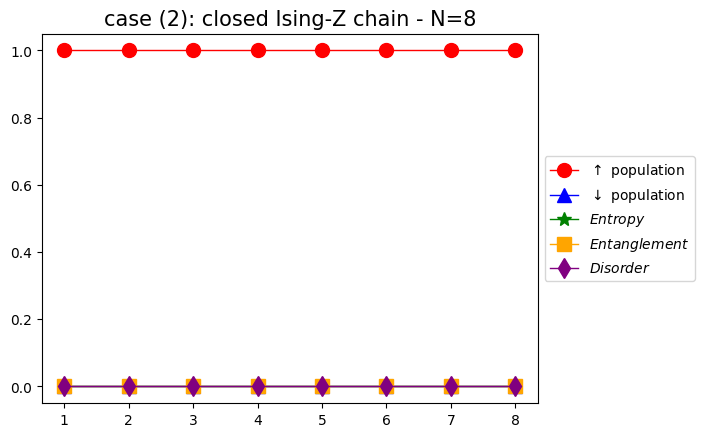

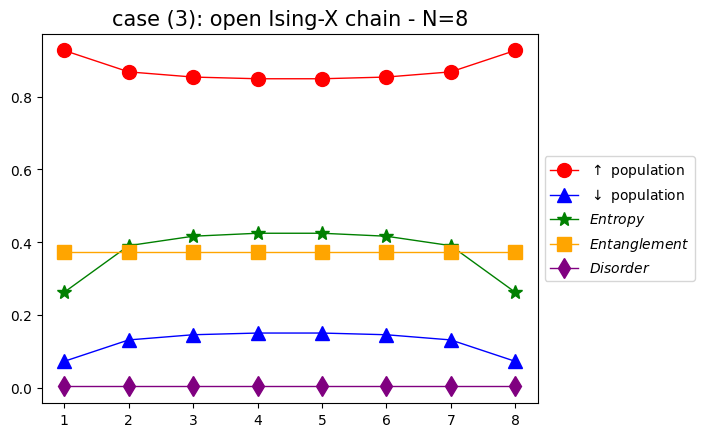

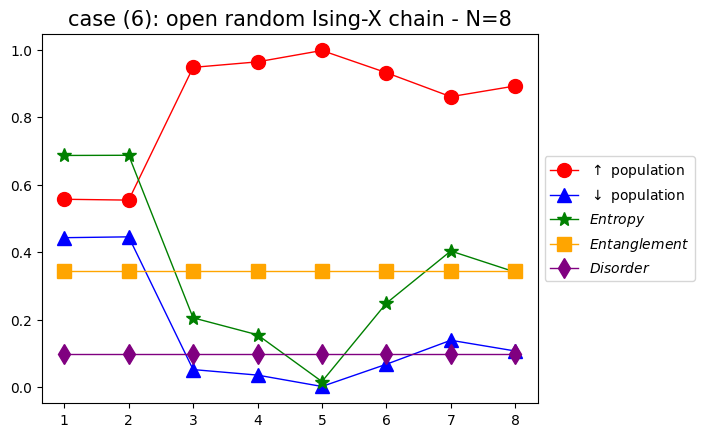

In [72]:
# EXPECT AT LEAST 1 MINUTE TO RUN THIS CELL!

H1 = H_cIZ_8  # case (2)
H2 = H_oIX_8  # case (3)
H3 = H_orIX_8 # case (6)

plot_231(H1, 'case (2): closed Ising-Z chain - N=8', mu=100, eps=1e-8, kmax=1e6)
plot_231(H2, 'case (3): open Ising-X chain - N=8', mu=100, eps=1e-8, kmax=1e6)
plot_231(H3, 'case (6): open random Ising-X chain - N=8', mu=10, eps=1e-8, kmax=5e5)